In [1]:
import torch
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader, TensorDataset

from collections import OrderedDict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyDOE import lhs
from scipy.stats import uniform,norm

import os
import re

os.chdir("/home/s2113174/Projects-1")

np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Making the data for an Inverse Problem following the parametric ODE

$$-\frac{d}{dx}(e^{\theta}\frac{du(x)}{dx}) = 1, \quad x\in (0,1),\theta \in [-1,1]$$
$$u(0) = 0, u(1)=1$$

with solution 
$$ u(x) = \frac{x - x^{2}}{2 e^{\theta}}$$

## The Problem consist in infering $ \alpha $

Text(0, 0.5, 'Observations')

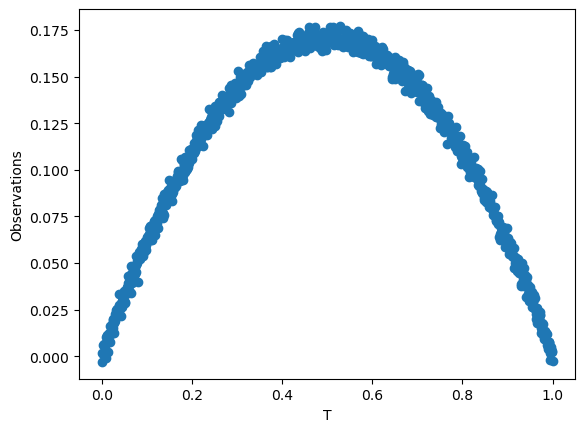

In [2]:
ns = 1
t= np.linspace(0,ns,1000)
mean, std = 0,np.sqrt(1e-5)
theta_t = np.zeros(1)

Exact = (t - t**2) / 2*np.exp(0.314)

noise_sol = Exact + np.random.normal(mean,std, len(t))

plt.scatter(t,noise_sol)
plt.xlabel("T")
plt.ylabel("Observations")


## Feed Forward Neural Network

In [3]:
# Deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # Number of layers
        self.depth = len(layers) - 1
        
        # Activation Function
        self.activation = torch.nn.Tanh
        
        # The following loop organized the layers of the NN         
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

## Parametric PINN for Inverse Problems

In [4]:
def DE(self,t,pr):
    """ The pytorch autograd version of calculating residual """
    u = self(torch.cat([t, pr], dim=1))
    
    u_t = torch.autograd.grad(
        u, t, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_tt = torch.autograd.grad(
        u_t, t, 
        grad_outputs=torch.ones_like(u_t),
        retain_graph=True,
        create_graph=True
    )[0]
    
    f = -torch.exp(pr)*u_tt - 1
    return f

In [5]:
DNN.DE = DE

In [6]:
def sample_ic(size):
    return np.zeros(size)

def sample_bc(size):
    return np.ones(size)

def samples_space(size,maxl):
    t_f_train = lhs(1, size)*maxl
    return t_f_train

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [7]:
def data_pde(size,maxl,minp,maxp):

    t, param = samples_space(size,maxl),samples_param(minp,maxp,(size,theta_t.shape[0]))

    X_u_train = torch.from_numpy(np.concatenate((t.reshape(-1,1),param),axis=1)).float().to(device)

    X_u_train = TensorDataset(X_u_train,torch.zeros_like(X_u_train[:,0]))
    X_u_train = DataLoader(X_u_train,batch_size=size)

    return X_u_train

def data_ic(size):
    ic = sample_ic(size)

    X_u_train = torch.from_numpy(ic.reshape(-1,1)).float().to(device)

    X_u_train = TensorDataset(X_u_train,torch.zeros_like(X_u_train[:,0]))
    X_u_train = DataLoader(X_u_train,batch_size=size)

    return X_u_train

def data_bc(size):
    bc = sample_bc(size)

    X_u_train = torch.from_numpy(bc.reshape(-1,1)).float().to(device)

    X_u_train = TensorDataset(X_u_train,torch.zeros_like(X_u_train[:,0]))
    X_u_train = DataLoader(X_u_train,batch_size=size)

    return X_u_train

In [8]:
def train(epochs, pinn,loss,optimizer,size,maxl,minp,maxp):
   
   print("Starting Training")

   #for epoch in range(epochs):
   itr_loss = 0.0   

   for i in range(epochs):

    ic,bc, t, param = sample_ic(size),sample_bc(size),samples_space(size,maxl),samples_param(minp,maxp,size)

    ic, bc, t, param = torch.tensor(ic).float().to(device),torch.tensor(bc).float().to(device), torch.tensor(t).float().to(device), torch.tensor(param).float().to(device)

    ic, bc ,t, param = Variable(ic,requires_grad=True).reshape(-1,1),Variable(bc,requires_grad=True).reshape(-1,1), Variable(t,requires_grad=True).reshape(-1,1), Variable(param,requires_grad=True).reshape(-1,1)

       
    def loss_func_train():
        
        optimizer.zero_grad()

        ic_pred,bc_pred,f_pred = pinn(torch.cat([ic, param], dim=1)), pinn(torch.cat([bc, param], dim=1)),pinn.DE(t,param)

        loss_u_ic,loss_u_bc,loss_f = loss(ic_pred,torch.zeros_like(t)),loss(bc_pred,torch.zeros_like(t)),loss(f_pred,torch.zeros_like(t))

        Loss =  loss_f + loss_u_ic + loss_u_bc

        if i % 10 == 0:
                print('Iter %d, Loss: %.5e, Loss_ic: %.5e, Loss_f: %.5e' % (i, Loss.item(), loss_u_ic.item(), loss_f.item()))
           
        Loss.backward() 
    
        return Loss

    optimizer.step(loss_func_train) 
    
    oupt = pinn(torch.cat([ic, param], dim=1))  

    loss_val = loss_func_train() 

    itr_loss += loss_val.item()  

In [9]:
# Number of observations
epochs = 50
nobs = 50
lr = 0.01

min_param , max_param = -1, 1

space = 1

layers = [2] + 1*[15] + [1]

In [10]:
model = DNN(layers)

In [11]:
loss = torch.nn.MSELoss(reduction ='mean')

optimizer = torch.optim.LBFGS(
    model.parameters(), lr=lr, max_iter=50000, max_eval=None, tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,line_search_fn="strong_wolfe" 
    )

#optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [12]:
train(epochs, model,loss,optimizer,nobs,space,min_param , max_param)

# model.load_state_dict(torch.load("../Projects-1/Physics _Informed_NN/Models/Param_model_2.pt"))
# model.eval()

Starting Training
Iter 0, Loss: 1.02622e+00, Loss_ic: 7.03205e-02, Loss_f: 8.77358e-01
Iter 0, Loss: 1.02198e+00, Loss_ic: 6.92540e-02, Loss_f: 8.75678e-01
Iter 0, Loss: 1.00350e+00, Loss_ic: 6.46904e-02, Loss_f: 8.68139e-01
Iter 0, Loss: 8.68381e-01, Loss_ic: 4.04820e-02, Loss_f: 7.88317e-01
Iter 0, Loss: 8.67468e-01, Loss_ic: 4.03878e-02, Loss_f: 7.87540e-01
Iter 0, Loss: 8.59451e-01, Loss_ic: 3.96131e-02, Loss_f: 7.80559e-01
Iter 0, Loss: 7.99264e-01, Loss_ic: 3.91025e-02, Loss_f: 7.11962e-01
Iter 0, Loss: 7.97862e-01, Loss_ic: 3.90055e-02, Loss_f: 7.10554e-01
Iter 0, Loss: 7.91613e-01, Loss_ic: 3.85936e-02, Loss_f: 7.04218e-01
Iter 0, Loss: 7.30545e-01, Loss_ic: 3.67525e-02, Loss_f: 6.35323e-01
Iter 0, Loss: 7.26551e-01, Loss_ic: 3.64349e-02, Loss_f: 6.31432e-01
Iter 0, Loss: 7.08879e-01, Loss_ic: 3.51173e-02, Loss_f: 6.13974e-01
Iter 0, Loss: 5.58520e-01, Loss_ic: 3.29973e-02, Loss_f: 4.38628e-01
Iter 0, Loss: 5.55545e-01, Loss_ic: 3.27123e-02, Loss_f: 4.36142e-01
Iter 0, Loss: 5.

In [14]:
torch.save(model.state_dict(),"../Projects-1/Physics _Informed_NN/Models/LA_toymodel_small_k.pt")

In [15]:
def test_set(max_space,obs,param,mean,std):

    t = np.linspace(0,max_space,obs)

    sol = (t - t**2) / (2*np.exp(param))

    noise_sol_test = sol + np.random.normal(mean,std, len(t))

    return t, noise_sol_test

In [16]:
# a dict to store the activations
forw_activation = {}
def forw_getActivation(name):
  # the hook signature
  def hook(model, input, output):
    forw_activation[name] = output.detach()
  return hook

h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_3'))

data_pde_ = data_pde(nobs,space,min_param , max_param)

t,param = next(iter(data_pde_))

t, param = Variable(t[:,0].reshape(-1,1),requires_grad=True),Variable(t[:,1:],requires_grad=True)

##############################################

u = model(torch.cat([t, param], dim=1))

u_t = torch.autograd.grad(
    u, t, 
    grad_outputs=torch.ones_like(u),
    retain_graph=True,
    create_graph=True
)[0]

u_tt = torch.autograd.grad(
    u_t, t, 
    grad_outputs=torch.ones_like(u_t),
    retain_graph=True,
    create_graph=True
)[0]

f_pred = -torch.exp(param)*u_tt - 1
#############################################

h1.remove()

loss_f = loss(f_pred,torch.zeros_like(f_pred))

df_f_1 = grad(loss_f, f_pred, create_graph=True)[0]

ddf_ff_1 = grad(df_f_1, f_pred, torch.ones_like(df_f_1))[0]

df_theta_1 = torch.cat((forw_activation['layers.activation_3'],torch.ones_like(ddf_ff_1)),1)

print(ddf_ff_1)

tensor([[0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400],
        [0.0400]])


In [17]:
# a dict to store the activations
forw_activation = {}
def forw_getActivation(name):
  # the hook signature
  def hook(model, input, output):
    forw_activation[name] = output.detach()
  return hook

h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_3'))

ic_pred = model(torch.cat([torch.zeros_like(t), param],dim=1))

h1.remove()

loss_u_ic = loss(ic_pred,torch.zeros_like(ic_pred))

df_f_2 = grad(loss_u_ic, ic_pred, create_graph=True)[0]

ddf_ff_2 = grad(df_f_2, ic_pred, torch.ones_like(df_f_1))[0]

df_theta_2 = torch.cat((forw_activation['layers.activation_3'],torch.ones_like(ddf_ff_2)),1)

print(df_theta_2)

tensor([[ 0.9361, -0.8171, -0.6767,  0.2173, -0.4482,  0.9911, -0.3441,  0.9934,
         -0.4154,  0.3142,  0.2910, -0.4029,  0.8001,  0.6504, -0.5595,  1.0000],
        [ 0.8518, -0.7015, -0.3767,  0.4173, -0.5308,  0.9598,  0.1749,  0.9843,
         -0.3637, -0.1106,  0.5001, -0.5244,  0.7617,  0.5968, -0.3947,  1.0000],
        [ 0.8527, -0.7026, -0.3794,  0.4160, -0.5303,  0.9602,  0.1710,  0.9844,
         -0.3641, -0.1074,  0.4986, -0.5235,  0.7620,  0.5972, -0.3960,  1.0000],
        [ 0.8421, -0.6904, -0.3480,  0.4315, -0.5369,  0.9549,  0.2147,  0.9832,
         -0.3596, -0.1438,  0.5144, -0.5330,  0.7585,  0.5924, -0.3806,  1.0000],
        [ 0.7517, -0.5987, -0.1204,  0.5290, -0.5793,  0.8960,  0.4792,  0.9725,
         -0.3291, -0.3734,  0.6109, -0.5931,  0.7337,  0.5591, -0.2718,  1.0000],
        [ 0.8775, -0.7325, -0.4577,  0.3740, -0.5126,  0.9715,  0.0535,  0.9871,
         -0.3758, -0.0107,  0.4558, -0.4980,  0.7711,  0.6096, -0.4356,  1.0000],
        [ 0.9393, -0.8

In [18]:
# a dict to store the activations
forw_activation = {}
def forw_getActivation(name):
  # the hook signature
  def hook(model, input, output):
    forw_activation[name] = output.detach()
  return hook

h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_3'))

bc_pred = model(torch.cat([torch.ones_like(t)*2, param],dim=1))

h1.remove()

loss_u_bc = loss(bc_pred,torch.zeros_like(bc_pred))

df_f_3 = grad(loss_u_bc, bc_pred, create_graph=True)[0]

ddf_ff_3 = grad(df_f_3, bc_pred, torch.ones_like(df_f_1))[0]

df_theta_3 = torch.cat((forw_activation['layers.activation_3'],torch.ones_like(ddf_ff_2)),1)

print(df_theta_3)

tensor([[ 0.2329, -0.6293, -0.3411, -0.7818, -0.0601,  1.0000, -0.7987,  0.3540,
         -0.9823,  0.9614, -0.1018,  0.1019, -0.5293,  0.6996,  0.6210,  1.0000],
        [-0.2031, -0.4320,  0.0714, -0.6785, -0.1674,  0.9999, -0.5077, -0.0681,
         -0.9801,  0.9100,  0.1465, -0.0529, -0.5965,  0.6520,  0.7359,  1.0000],
        [-0.1998, -0.4337,  0.0682, -0.6794, -0.1666,  0.9999, -0.5107, -0.0648,
         -0.9801,  0.9106,  0.1446, -0.0517, -0.5960,  0.6523,  0.7351,  1.0000],
        [-0.2357, -0.4144,  0.1042, -0.6690, -0.1756,  0.9998, -0.4764, -0.1017,
         -0.9799,  0.9040,  0.1653, -0.0649, -0.6014,  0.6481,  0.7434,  1.0000],
        [-0.4555, -0.2759,  0.3335, -0.5928, -0.2347,  0.9996, -0.2112, -0.3370,
         -0.9784,  0.8472,  0.2991, -0.1519, -0.6359,  0.6182,  0.7932,  1.0000],
        [-0.1036, -0.4825, -0.0266, -0.7053, -0.1430,  0.9999, -0.5933,  0.0326,
         -0.9806,  0.9258,  0.0898, -0.0172, -0.5817,  0.6634,  0.7124,  1.0000],
        [ 0.2575, -0.6

In [19]:
wt,bias = model.layers[-1].weight, model.layers[-1].bias

param_MAP = torch.cat((wt,bias.reshape(1,1)),1) 

nparam = param_MAP.reshape(-1).shape

print(df_theta_1.shape,df_theta_2.shape,df_theta_3.shape,nparam)

torch.Size([50, 16]) torch.Size([50, 16]) torch.Size([50, 16]) torch.Size([16])


In [20]:
H = (nobs/2)*(torch.sum(df_theta_1*ddf_ff_1*df_theta_1,axis=0)+ torch.sum(df_theta_2*ddf_ff_2*df_theta_2,axis=0)+torch.sum(df_theta_3*ddf_ff_3*df_theta_3,axis=0))

print(H,H.shape)

tensor([ 76.2062,  70.7105,  34.2917,  35.8897,  20.9530, 146.1301,  39.7053,
        100.0330,  80.4978,  63.2940,  15.5591,  17.9482,  62.2900,  63.3131,
         38.9397, 150.0000]) torch.Size([16])


In [21]:
_sigma_noise=torch.tensor([1])
temperature=torch.tensor([1])

def sigma_noise():
    return _sigma_noise

def _H_factor():
    sigma2 = sigma_noise().square()
    return 1 / sigma2 / temperature

def prior_precision_diag(prior_precision,n_params):
    """Obtain the diagonal prior precision \\(p_0\\) constructed from either
    a scalar, layer-wise, or diagonal prior precision.

    Returns
    -------
    prior_precision_diag : torch.Tensor
    """
    if len(prior_precision) == 1:  # scalar
        return prior_precision * torch.ones(n_params, device=device)

    elif len(prior_precision) == n_params:  # diagonal
        return prior_precision

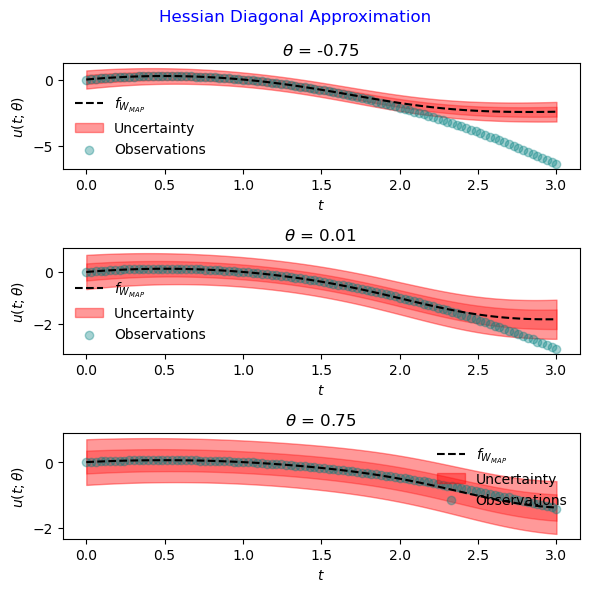

In [22]:
import matplotlib.pyplot as plt
from matplotlib import cm


param_trained =  np.array([-0.75,0.01,0.75])

prior_pre=torch.tensor([1])

prior_pre_diag = prior_precision_diag(prior_pre,nparam)

# Plotting
fig = plt.figure(figsize=(6,6))
plt.suptitle("Hessian Diagonal Approximation",color = "blue")

for n,pr in enumerate(param_trained):

    t, noise_sol_test = test_set(3,100,pr,mean,std)

    data_test = np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(pr)))

    ######################################################################################

    forw_activation_ = {}
    h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_3'))

    f  = model(torch.tensor(data_test).float()).detach().cpu().numpy()

    h1.remove()

    phi = forw_activation['layers.activation_3']

    bsize = phi.shape[0]
    output_size = f.shape[-1]

    # calculate Jacobians using the feature vector 'phi'
    identity = torch.eye(output_size, device=device).unsqueeze(0).tile(bsize, 1, 1)
    # Jacobians are batch x output x params
    Js = torch.einsum('kp,kij->kijp', phi, identity).reshape(bsize, output_size, -1)
    Js = torch.cat([Js, identity], dim=2).float()

    post_presicion = _H_factor() * H + prior_pre_diag


    post_variance = 1 / post_presicion

    functional_var = torch.einsum('ncp,p,nkp->nck', Js, post_variance.float(), Js)

    #######################################################################################
    f_mu = f.reshape(-1)
    f_sigma = functional_var.squeeze().sqrt().cpu().numpy().reshape(-1)
    

    plt.subplot(3, 1, n + 1)

    plt.title(fr"$\theta$ = {pr:0.2f} ")
    plt.plot(t, f_mu, "--",color="black",label = r'$f_{W_{MAP}}$')
    plt.fill_between(t, f_mu+f_sigma,f_mu-f_sigma,alpha=0.3, color = "red")
    plt.fill_between(t, f_mu+2*f_sigma,f_mu-2*f_sigma,alpha=0.4, color = "red",label = "Uncertainty")
    plt.scatter(t,noise_sol_test, label = "Observations",color= "teal",alpha = 0.35)


    plt.xlabel("$t$")
    plt.ylabel("$u(t;\\theta)$")
    plt.legend(frameon=False)
    plt.tight_layout()


In [23]:
from torch.distributions.multivariate_normal import _precision_to_scale_tril


Hfull = (nobs/2)*(torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_1, df_theta_1), ddf_ff_1),axis=0) +\
                  torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_2, df_theta_2), ddf_ff_2),axis=0)+\
                    torch.sum(torch.einsum("bcd,ba->bcd",torch.einsum('bc,bd->bcd', df_theta_3, df_theta_3), ddf_ff_3),axis=0))

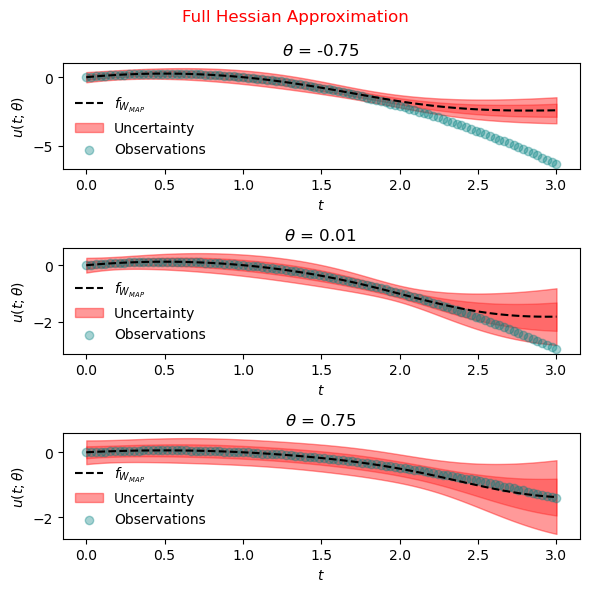

In [24]:
param_trained =  np.array([-0.75,0.01,0.75])

prior_pre=torch.tensor([1])

prior_pre_diag_ = prior_precision_diag(prior_pre,nparam)

# Plotting
fig = plt.figure(figsize=(6,6))
plt.suptitle("Full Hessian Approximation",color = "red")

for n,pr in enumerate(param_trained):

    t, noise_sol_test = test_set(3,100,pr,mean,std)

    data_test = np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(pr)))

    ######################################################################################

    forw_activation_ = {}
    h1 = model.layers[-2].register_forward_hook(forw_getActivation('layers.activation_3'))

    f  = model(torch.tensor(data_test).float()).detach().cpu().numpy()

    h1.remove()

    phi = forw_activation['layers.activation_3']

    bsize = phi.shape[0]
    output_size = f.shape[-1]

    # calculate Jacobians using the feature vector 'phi'
    identity = torch.eye(output_size, device=device).unsqueeze(0).tile(bsize, 1, 1)
    # Jacobians are batch x output x params
    Js = torch.einsum('kp,kij->kijp', phi, identity).reshape(bsize, output_size, -1)
    Js = torch.cat([Js, identity], dim=2)

    post_presicion = _H_factor() * Hfull + torch.diag(prior_pre_diag_)


    post_scale = _precision_to_scale_tril(post_presicion)

    post_cov = post_scale @ post_scale.T

    functional_var = torch.einsum('ncp,pq,nkq->nck', Js, post_cov.float(), Js)

    #######################################################################################
    f_mu = f.reshape(-1)
    f_sigma = functional_var.squeeze().sqrt().cpu().numpy().reshape(-1)



    plt.subplot(3, 1, n + 1)

    plt.title(fr"$\theta$ = {pr:0.2f} ")
    plt.plot(t, f_mu, "--",color="black",label = r'$f_{W_{MAP}}$')
    plt.fill_between(t, f_mu+f_sigma,f_mu-f_sigma,alpha=0.3, color = "red")
    plt.fill_between(t, f_mu+2*f_sigma,f_mu-2*f_sigma,alpha=0.4, color = "red",label = "Uncertainty")
    plt.scatter(t,noise_sol_test, label = "Observations",color= "teal",alpha = 0.35)


    plt.xlabel("$t$")
    plt.ylabel("$u(t;\\theta)$")
    plt.legend(frameon=False)
    plt.tight_layout()

plt.show()

## MCMC Step

In [25]:
def log_prior_alpha(alpha): #function to evaluate prior pdf of given parameters
    return norm.logpdf(alpha,loc = 0,scale = 1.5)

def proposals(alpha,dt):
    return np.random.normal(alpha,dt)

In [26]:
def log_likelihood(surrogate,alpha,t,y_dat,sig = std):
    
    data_ = np.hstack((t.flatten()[:,None], np.ones_like(t).flatten()[:,None]*(alpha)))

    surg = surrogate(torch.tensor(data_).float()).detach().cpu().numpy().reshape(-1,)
        
    #return np.sum(-np.log(np.sqrt(2* np.pi*sig)) - ((y_dat-surg)**2) / (2*sig))

    return np.sum(- ((y_dat-surg)**2) / (2*sig**2))

def log_likelihood_ex(alpha,t,y,sig = std):

    surg_exact = (t - t**2) / (2*np.exp(alpha))

    #return np.sum(-np.log(np.sqrt(2* np.pi*sig**2)) - ((y-surg_exact)**2) / (2*sig**2))
    return np.sum(-((y-surg_exact)**2) / (2*sig**2))

In [27]:
def log_posterior_ex(alpha,t,y):
    return  log_likelihood_ex(alpha,t,y) + log_prior_alpha(alpha)

def log_posterior_nn(model,alpha,t,y):
    return  log_likelihood(model,alpha,t,y) + log_prior_alpha(alpha)

In [28]:
theta_h = 0.314
t, noise_sol_test = test_set(ns,1000,theta_h,mean,std)

In [29]:
alpha_ = np.linspace(-1,1,200)

alpha_fc,alpha_fc_2,alpha_fc_3 = [],[],[]
alpha_fc_nn,alpha_fc_2_nn,alpha_fc_3_nn = [],[],[]


for alp in alpha_:
    alpha_fc.append(log_posterior_ex(alp,t[:100],noise_sol_test[:100]))
    alpha_fc_nn.append(log_posterior_nn(model,alp,t[:100],noise_sol_test[:100]))
    
    alpha_fc_2.append(log_posterior_ex(alp,t[:500],noise_sol_test[:500]))
    alpha_fc_2_nn.append(log_posterior_nn(model,alp,t[:500],noise_sol_test[:500]))
    
    alpha_fc_3.append(log_posterior_ex(alp,t,noise_sol_test))
    alpha_fc_3_nn.append(log_posterior_nn(model,alp,t,noise_sol_test))

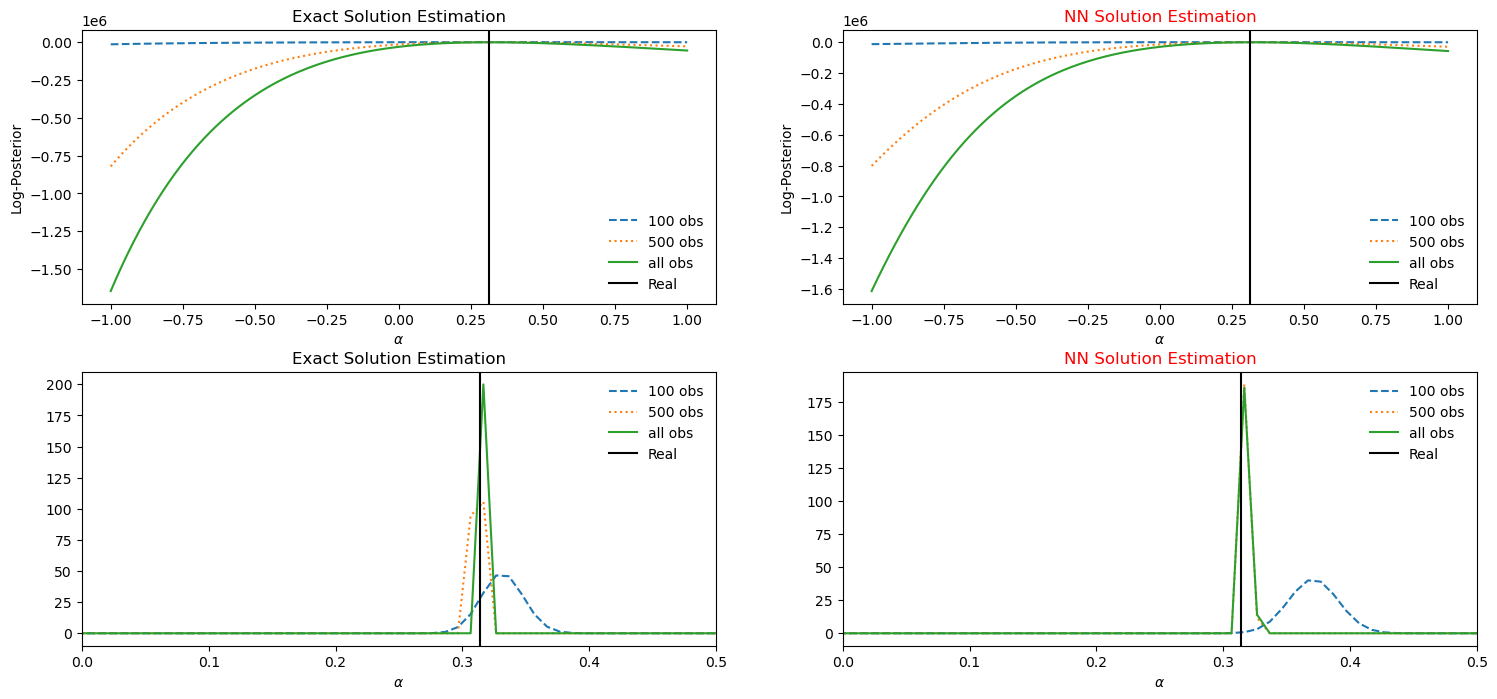

In [30]:
fig = plt.figure(figsize=(18,8))
plt.subplots_adjust(hspace=0.25)

plt.subplot(2, 2, 1)
plt.plot(alpha_,alpha_fc ,linestyle = '--', label = "100 obs")
plt.plot(alpha_,alpha_fc_2,linestyle = ':', label = "500 obs")
plt.plot(alpha_,alpha_fc_3, label = "all obs")

plt.axvline(x = theta_h, color = 'black', label = 'Real')

plt.title("Exact Solution Estimation")
plt.ylabel("Log-Posterior")
plt.xlabel(r"$\alpha$")
plt.legend(frameon =False)


plt.subplot(2, 2, 2)
plt.plot(alpha_,alpha_fc_nn ,linestyle = '--', label = "100 obs")
plt.plot(alpha_,alpha_fc_2_nn,linestyle = ':', label = "500 obs")
plt.plot(alpha_,alpha_fc_3_nn, label = "all obs")

plt.axvline(x = theta_h, color = 'black', label = 'Real')

plt.title("NN Solution Estimation",color = "red")
plt.ylabel("Log-Posterior")
plt.xlabel(r"$\alpha$")
plt.legend(frameon =False)


plt.subplot(2, 2, 3)
plt.plot(alpha_,200*np.exp(alpha_fc)/np.sum(np.exp(alpha_fc)) ,linestyle = '--', label = "100 obs")
plt.plot(alpha_,200*np.exp(alpha_fc_2)/np.sum(np.exp(alpha_fc_2)),linestyle = ':', label = "500 obs")
plt.plot(alpha_,200*np.exp(alpha_fc_3)/np.sum(np.exp(alpha_fc_3)), label = "all obs")

plt.axvline(x = theta_h, color = 'black', label = 'Real')

plt.title("Exact Solution Estimation")
plt.xlabel(r"$\alpha$")
plt.xlim(0,0.5)
plt.legend(frameon =False)


plt.subplot(2, 2, 4)
plt.plot(alpha_,200*np.exp(alpha_fc_nn)/np.sum(np.exp(alpha_fc_nn)) ,linestyle = '--', label = "100 obs")
plt.plot(alpha_,200*np.exp(alpha_fc_2_nn)/np.sum(np.exp(alpha_fc_2_nn)),linestyle = ':', label = "500 obs")
plt.plot(alpha_,200*np.exp(alpha_fc_3_nn)/np.sum(np.exp(alpha_fc_3_nn)), label = "all obs")

plt.axvline(x = theta_h, color = 'black', label = 'Real')

plt.title("NN Solution Estimation",color = "red")
plt.xlabel(r"$\alpha$")
plt.xlim(0,0.5)
plt.legend(frameon =False)

In [31]:
def Metropolis_Hastings(t,y_dat,nChains, exact = False):

    alpha = 5

    alpha_samp = []
    acceptance_rate, dt = 0, 0.5

    dt_tracker = []
    for i in range(nChains):

        log_posterior =  log_posterior_ex(alpha,t,y_dat) if exact else log_posterior_nn(model,alpha,t,y_dat)
        #log_posterior = log_posterior_ex(alpha,t,y_dat)

        alpha_proposal = proposals(alpha,dt)

        log_posterior_proposal = log_posterior_ex(alpha_proposal,t,y_dat) if exact else log_posterior_nn(model,alpha_proposal,t,y_dat)
        #log_posterior_proposal = log_posterior_ex(alpha_proposal,t,y_dat)

        accept_u = np.random.uniform(0,1)

        ratio = np.exp(log_posterior_proposal-log_posterior, dtype=np.float64)

        a = np.min([1.,ratio])

        if accept_u < a:
            alpha = alpha_proposal
            acceptance_rate += 1
        
        dt = dt + dt*(a - 0.234)/ (i+1) 
        dt_tracker.append(dt)
        alpha_samp.append(alpha)


    print(f"Acceptance Rate: {acceptance_rate/nChains:.3f}")

    return alpha_samp,dt_tracker

In [32]:
def acf(x, length=20):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1] for i in range(1, length)])

In [33]:
alpha_samp,dt_tracker = Metropolis_Hastings(t,noise_sol_test,100000)

/tmp/ipykernel_6232/1792166774.py:21: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(log_posterior_proposal-log_posterior, dtype=np.float64)


KeyboardInterrupt: 

In [ ]:
alpha_samp_true,dt_tracker_true = Metropolis_Hastings(t,noise_sol_test,100000,exact = True)

/tmp/ipykernel_2216271/1792166774.py:21: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(log_posterior_proposal-log_posterior, dtype=np.float64)


Acceptance Rate: 0.006


Text(0.5, 0, 'Iteration')

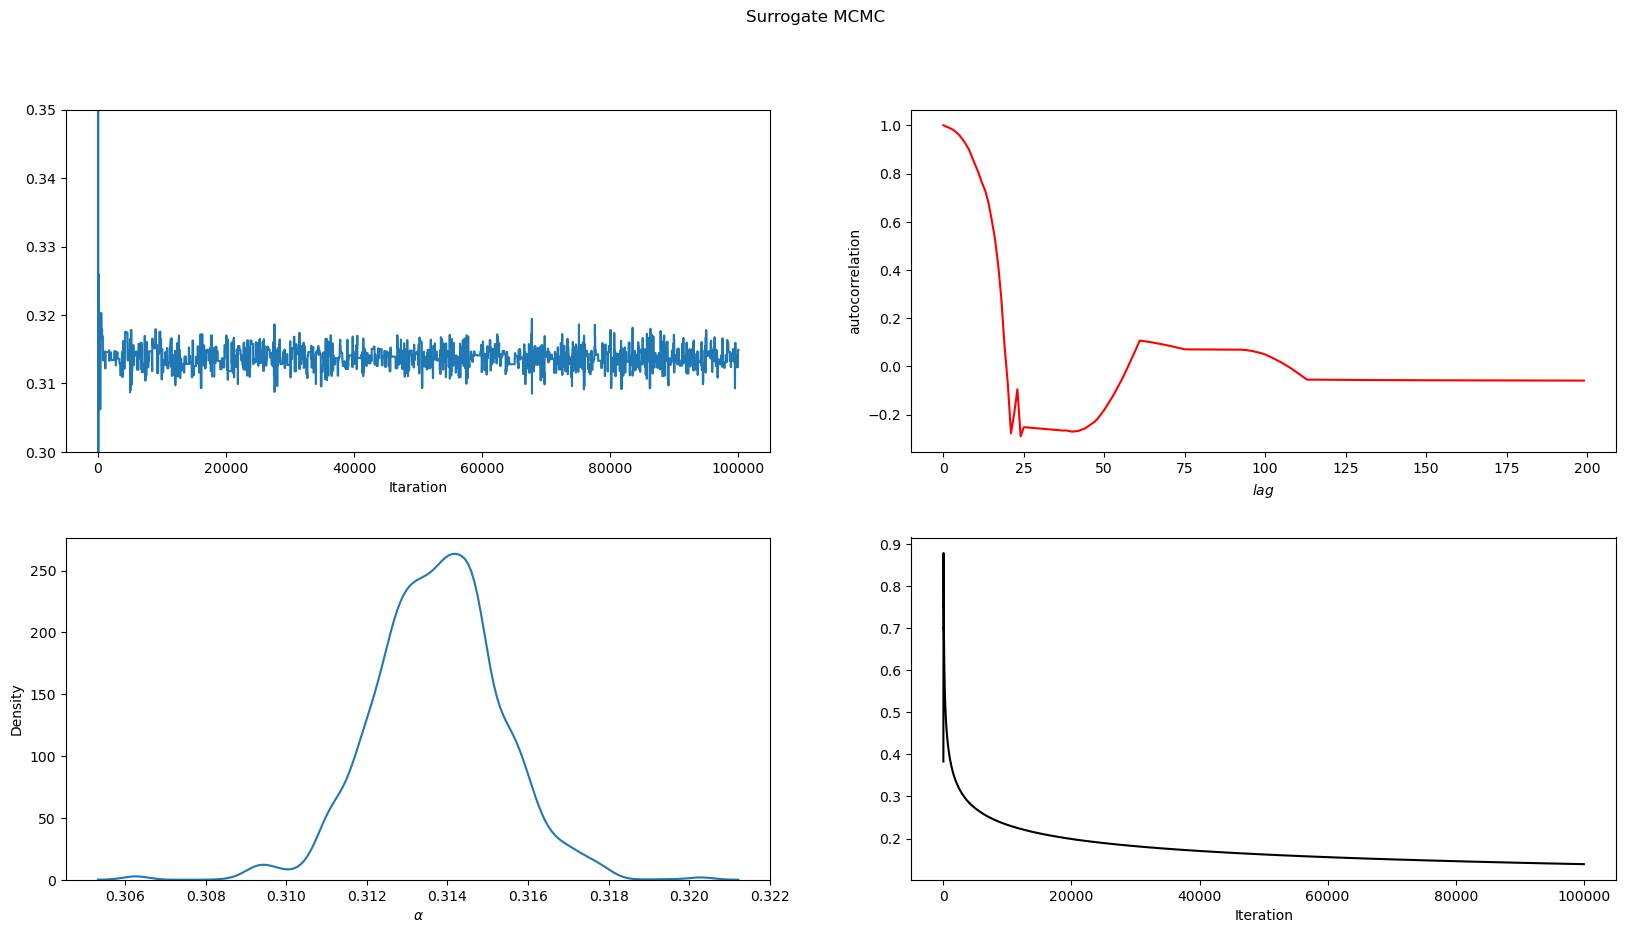

In [ ]:
import seaborn as sns

fig = plt.figure(figsize=(20,10))
plt.suptitle("Surrogate MCMC")
plt.subplots_adjust(hspace=0.25)

plt.subplot(2, 2, 1)
plt.plot(alpha_samp)
plt.xlabel("Itaration")
plt.ylim(0.3,0.35)

plt.subplot(2, 2, 2)
plt.plot(acf(alpha_samp,200),color = "red")
plt.xlabel(r"$lag$")
plt.ylabel(r"autocorrelation")


plt.subplot(2, 2, 3)
#plt.hist(alpha_samp[200:],color = "orange",alpha = 0.5)
#plt.plot(alpha_,200*np.exp(alpha_fc_3)/np.sum(np.exp(alpha_fc_3)), label = "all obs")
sns.kdeplot(alpha_samp[200:],bw_adjust=2)
plt.xlabel(r"$\alpha$")
#plt.xlim(0.3,0.32)

plt.subplot(2, 2, 4)
plt.plot(dt_tracker,color = "black")
plt.xlabel("Iteration")

Text(0.5, 0, 'Iteration')

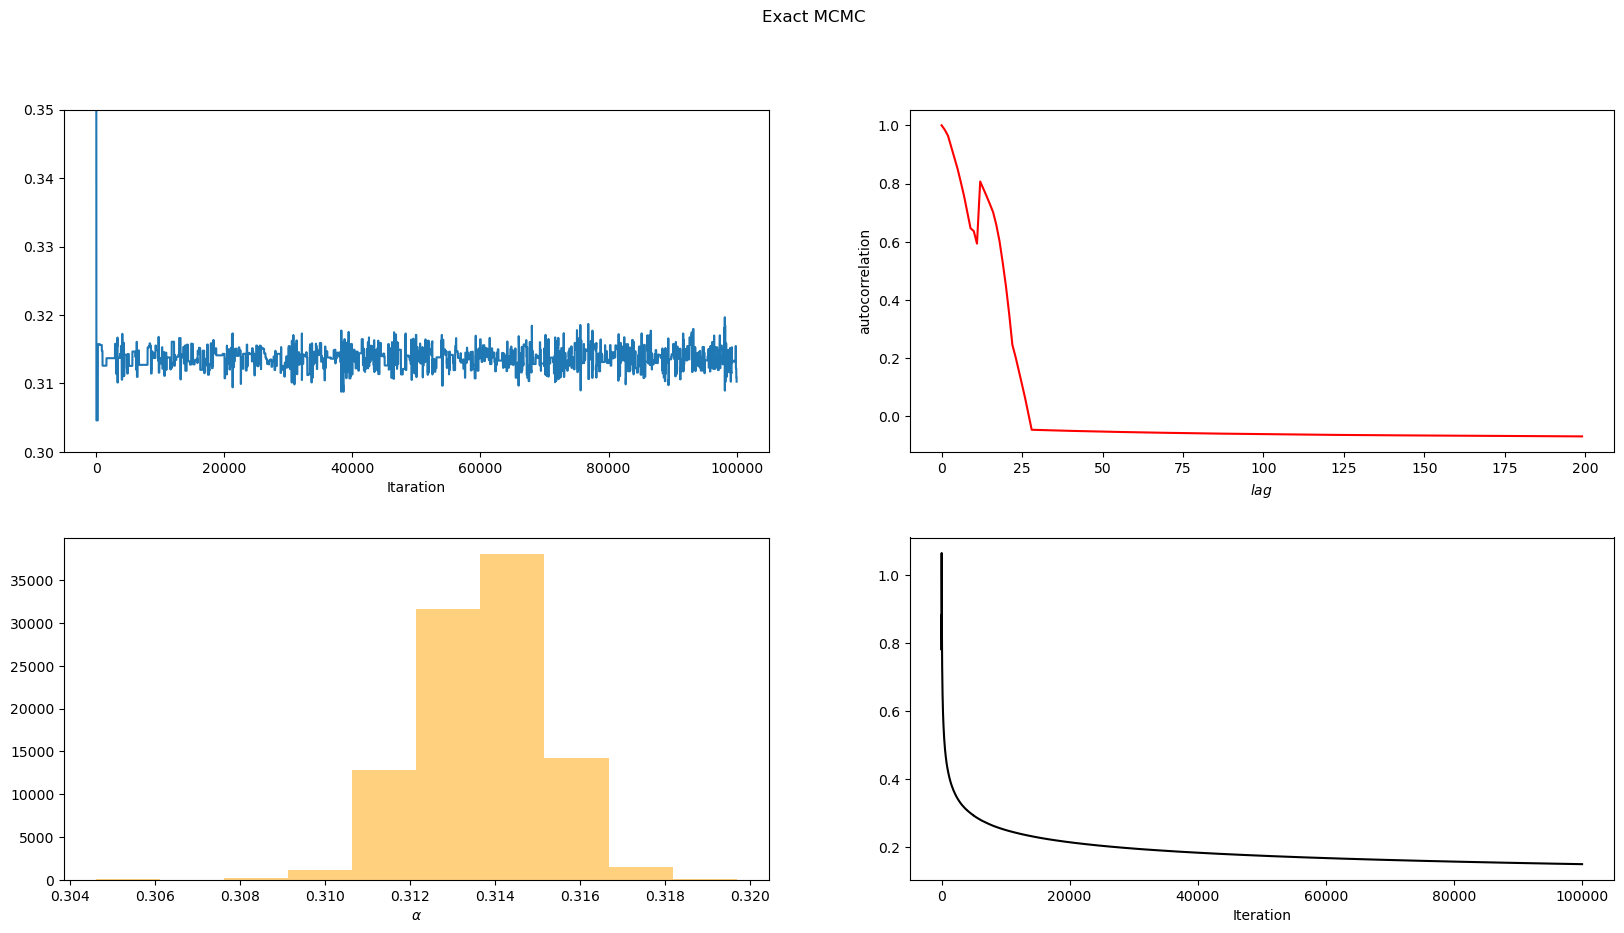

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.suptitle("Exact MCMC")

plt.subplots_adjust(hspace=0.25)

plt.subplot(2, 2, 1)
plt.plot(alpha_samp_true)
plt.xlabel("Itaration")
plt.ylim(0.3,0.35)


plt.subplot(2, 2, 2)
plt.plot(acf(alpha_samp_true,200),color = "red")
plt.xlabel(r"$lag$")
plt.ylabel(r"autocorrelation")


plt.subplot(2, 2, 3)
plt.hist(alpha_samp_true[200:],color = "orange",alpha = 0.5)
plt.xlabel(r"$\alpha$")

plt.subplot(2, 2, 4)
plt.plot(dt_tracker_true,color = "black")
plt.xlabel("Iteration")